# Machine Learning in Crowd Modelling and Simulation

In this task we implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from utilities import parser_array2obj, execute_rimea_4
from visualization import visualize_state
from main import crowd_simulator
from game_gui import start_game_gui
from pathlib import Path
import pandas as pd
import os 
from shutil import copyfile

%reload_ext autoreload
%autoreload 2
%matplotlib notebook

pygame 2.0.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Some conventions
Throughout this notebook and in the simulations we will follow some labelling conventions for clarity. These are listen in the table below:

|Numerical Encoding|Description|Color Assignment in GUI and visualizations| |
|---|---|---|---|
|0|Empty Cell| <span style="color:blue">Blue</span>.  ||
|1|Pedestrian|  <span style="color:red">Red</span>. | |
|2|Obstacle| <span style="color:yellow">Yellow</span>.  |   |
|3|Target|  <span style="color:green">Green</span>. ||


# Task 1: The setup

It is possible to execute the crowd simulator in two ways. The first is to simply execute the `main.py` file i.e. `python3 main.py` and then following the instructions on the CLI. The second method is to execute it by calling the appropriate function and methods in the jupyter notebook environment. In order to show the functionality of the simulator, we will first make use of the pygame GUI. In subsequent tasks, since we wish to show states and specific plots, we will use the jupyter notebook environment to run the simulations.

Here the user has two options

### Option 1: Load scenario
If you wish to load a scenario then type y in the following cell block. A list of available scenarios will be printed. Enter the id number of the scenario you wish to load and this will be loaded into a variable.

Please note that for the presaved scenario, the cell size have been scaled. This scaling is defined in the table below:

|Scenario |Length of one cell in meters| |
|---|---|---|
|task_2.csv|1| |
|task_3.csv|1|  |
|task_4.csv|1|    |
|Chicken Test|1|  |
|RiMEA 1|0.4|  |
|RiMEA 4|0.33|  |
|RiMEA 6|0.5|  |
|RiMEA 7|1|  |

### Option 2: Make customer scenario
If you wish to make own scenario then type n in the following cell block. You will be asked for the size of the grid you wish to generate. Enter the row and column numbers. Finally a GUI will pop up. You can make a scenario there. Type in `P` to add a pedestrian, `O` for object and `T` for target. Please note all of these need to be in **upper case**. If you wish for a cell to remain empty you can leave it as it is. Once you are finished simply close the GUI. The scenario will be saved in a variable for further processing. 


In [4]:
crowd_simulator()

 Leave answers empty for default 
Do you want to load a scenario? (y/n)y
Available scenario files are: 
Scenario 0 :  rimea_test7.csv
Scenario 1 :  rimea_test4.csv
Scenario 2 :  task_3.csv
Scenario 3 :  rimea_test6.csv
Scenario 4 :  chicken_test_multi_peds.csv
Scenario 5 :  task_4.csv
Scenario 6 :  chicken_test.csv
Scenario 7 :  multiple_targets.csv
Scenario 8 :  rimea_test1.csv
Scenario 9 :  ped_after_ped.csv
Scenario 10 :  task_2.csv
Please select which scenario you wish to load. Enter scenario id:4
Initial state of the loaded scenario:
Would you like to use Dijkstra-algorithm? (y/n)y
Maximum number of steps: (Positive integer)30


# Task 2: Single Pedestrian

### The simulation
We will now simulate the loaded scenario with our simple update step i.e. rudementary obstical avoidance and pedestrian repulsion. The scenario is such that we have a grid of 50x50 cells and a pedestrian at position (5,25) and a target at (25,25). Let us see how the pedestrian progresses.

**NOTE: This simulation can also be executed using the pygame GUI. Simply select load scenario and select the task_1.csv scenario file.**
The results will be visualized with the help of a matplotlib animation. The initial state of the scenario is shown below:

<IPython.core.display.Javascript object>


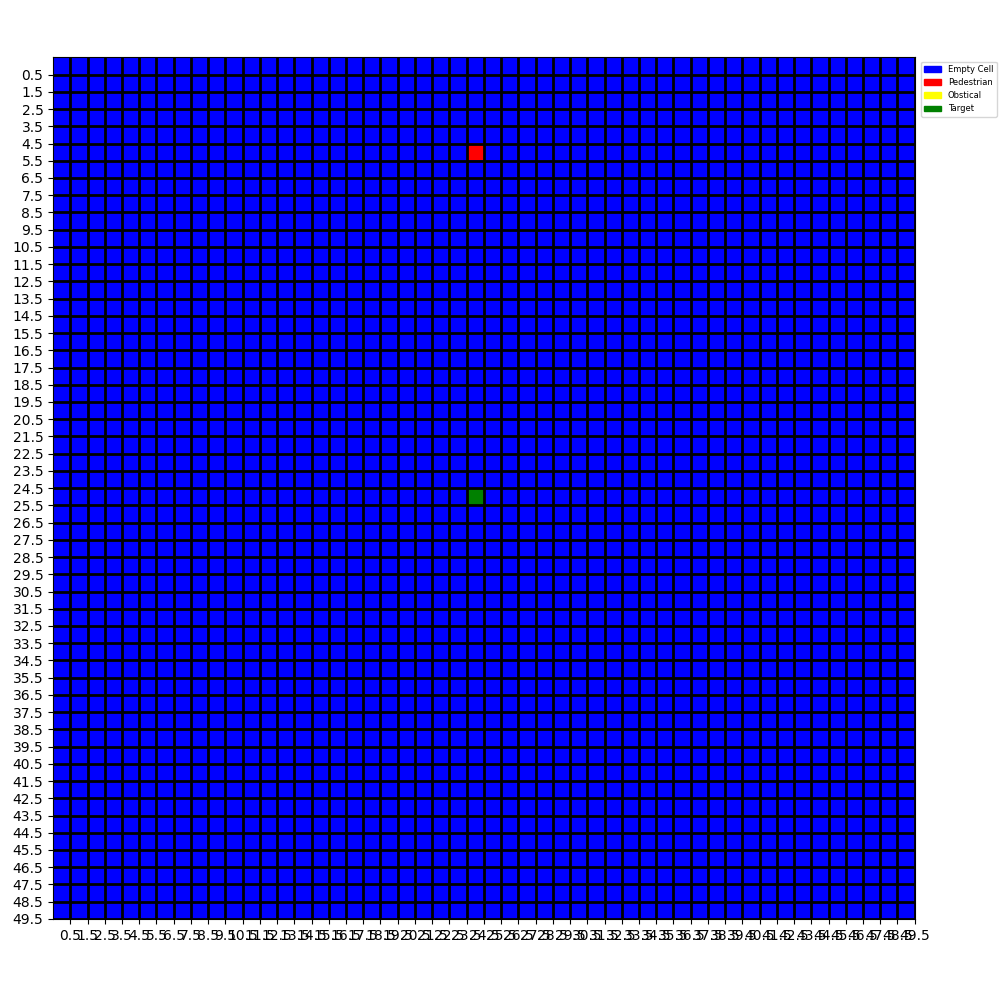

In [4]:
with open('./scenarios/task_2.csv', newline='') as csvfile:
    task_2 = np.array(list(csv.reader(csvfile))).astype(int)
    task_2 = parser_array2obj(task_2)
visualize_state(task_2.to_array())

**Let us simulate this for 25 steps and animate**

The simulation was took 20 steps and was executed in 6.0 seconds.


<IPython.core.display.Javascript object>


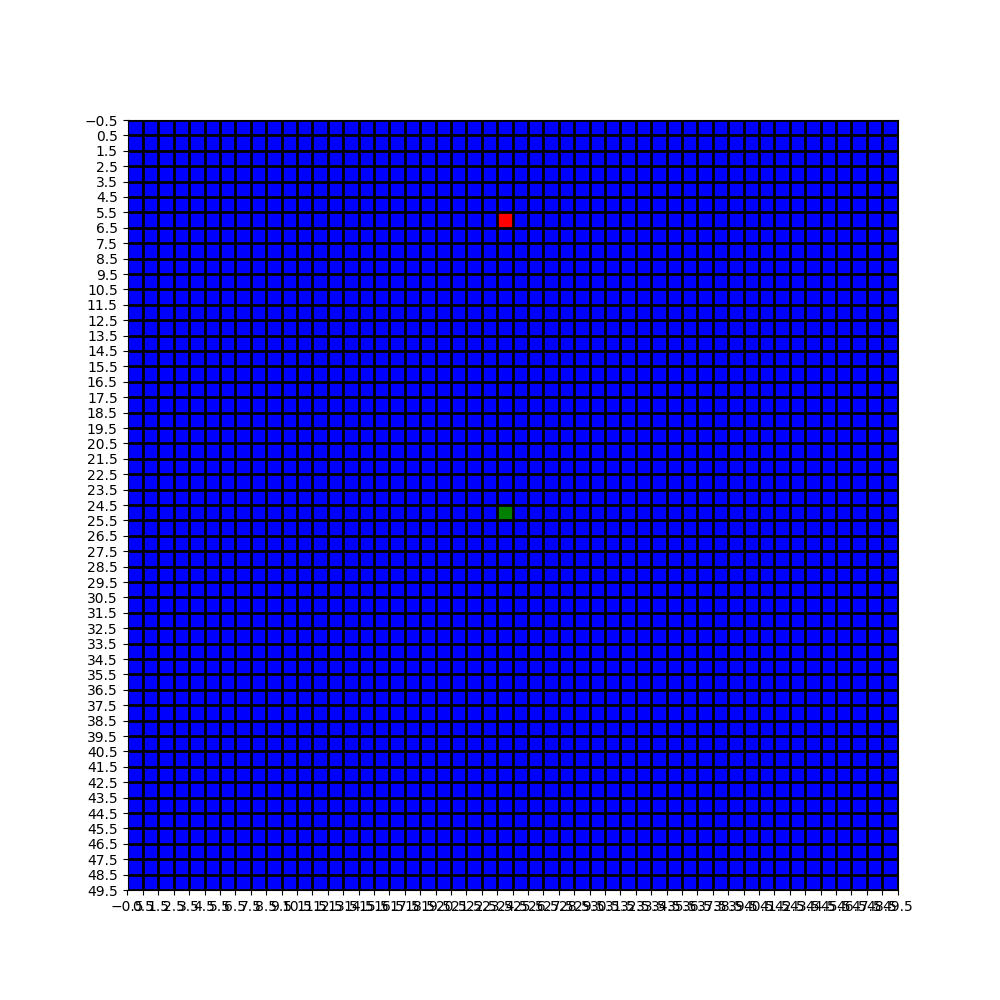

In [5]:
task_2.simulate(25)
task_2.animate()

### Observations

In this simple case, we use the distance of cells to the target as our cost operator for the pedestrian to decide their next move. A visualization of the cost can be seen below:

<IPython.core.display.Javascript object>


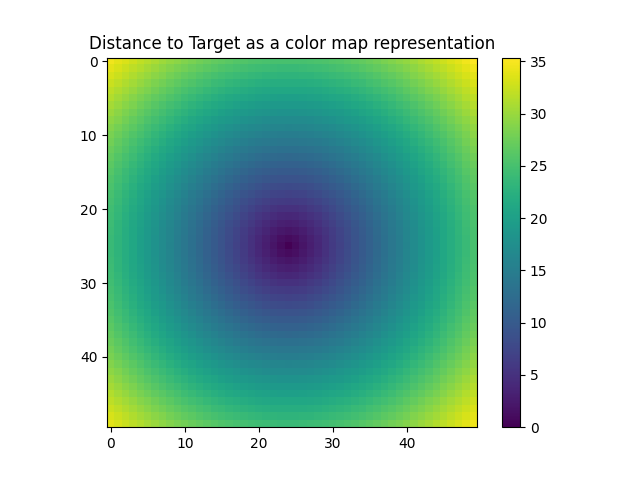

Text(0.5, 1.0, 'Distance to Target as a color map representation')

In [6]:
fig = plt.figure()
cost_task_2 = task_2.get_distance_to_target()
plt.imshow(cost_task_2)
plt.colorbar()
plt.title("Distance to Target as a color map representation")

# Task 3: Pedestrian Interaction

In this task we will show how pedestrians interact with each other in a  given scenario.
In order to model the pedestrian interaction we use the following formula for modelling repulsion:

### cost = $\frac{1}{e(r^2 - r_{max}^2)}$

<IPython.core.display.Javascript object>


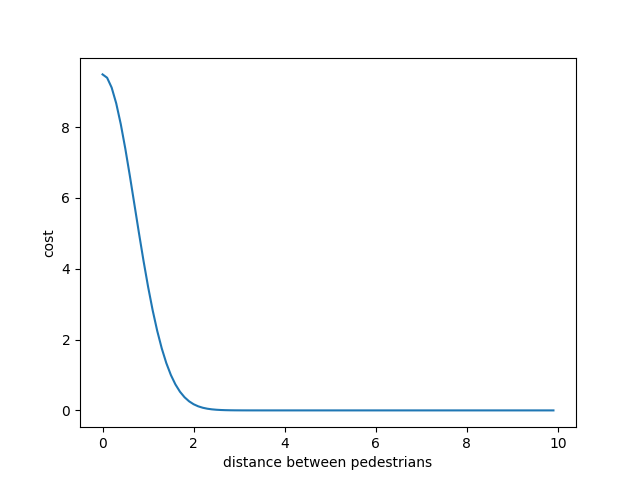

In [7]:
x = np.arange(0,10,0.1)
y = 1/np.exp(x**2 - 1.5**2)
fig, ax = plt.subplots(1,1)
ax.plot(x,y)
ax.set_ylabel('cost')
ax.set_xlabel('distance between pedestrians')
plt.show()

<IPython.core.display.Javascript object>


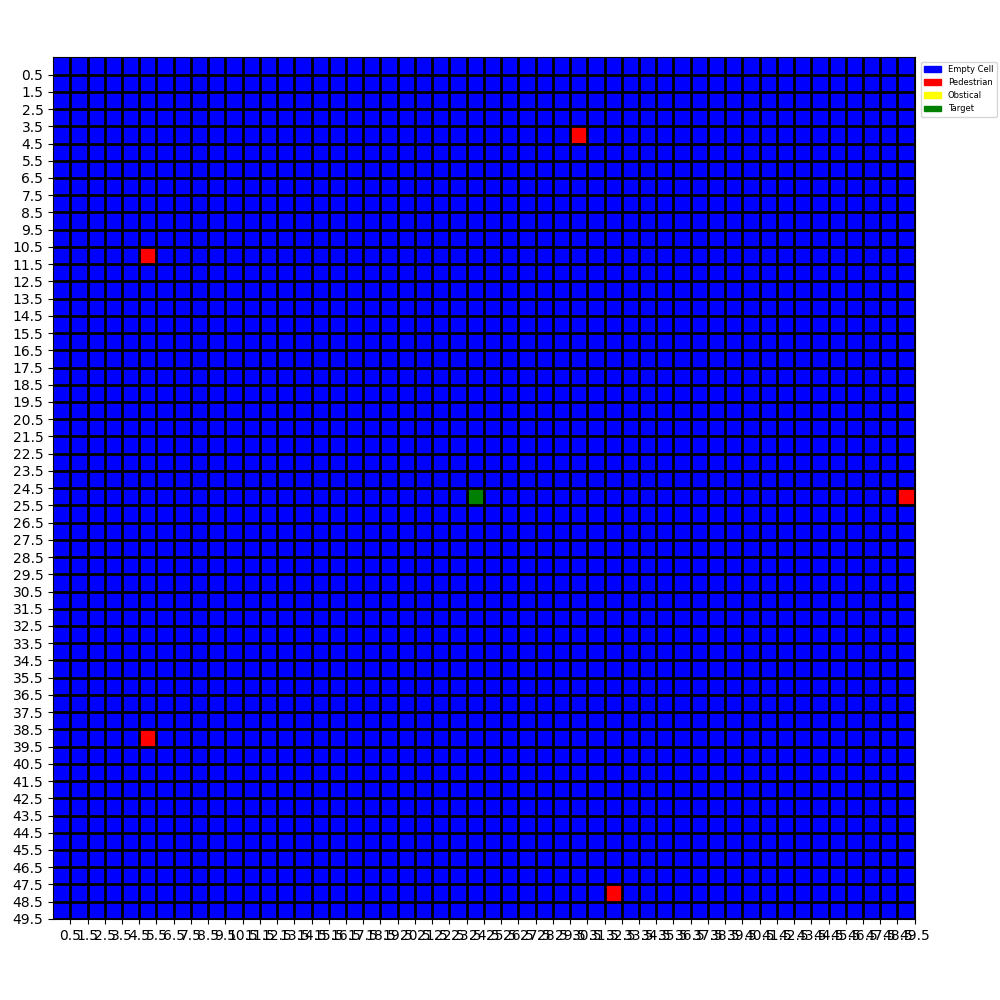

In [10]:
with open('./scenarios/task_3.csv', newline='') as csvfile:
    task_3 = np.array(list(csv.reader(csvfile))).astype(int)
    task_3 = parser_array2obj(task_3)
visualize_state(task_3.to_array())

The simulation was took 29 steps and was executed in 8.7 seconds.


<IPython.core.display.Javascript object>


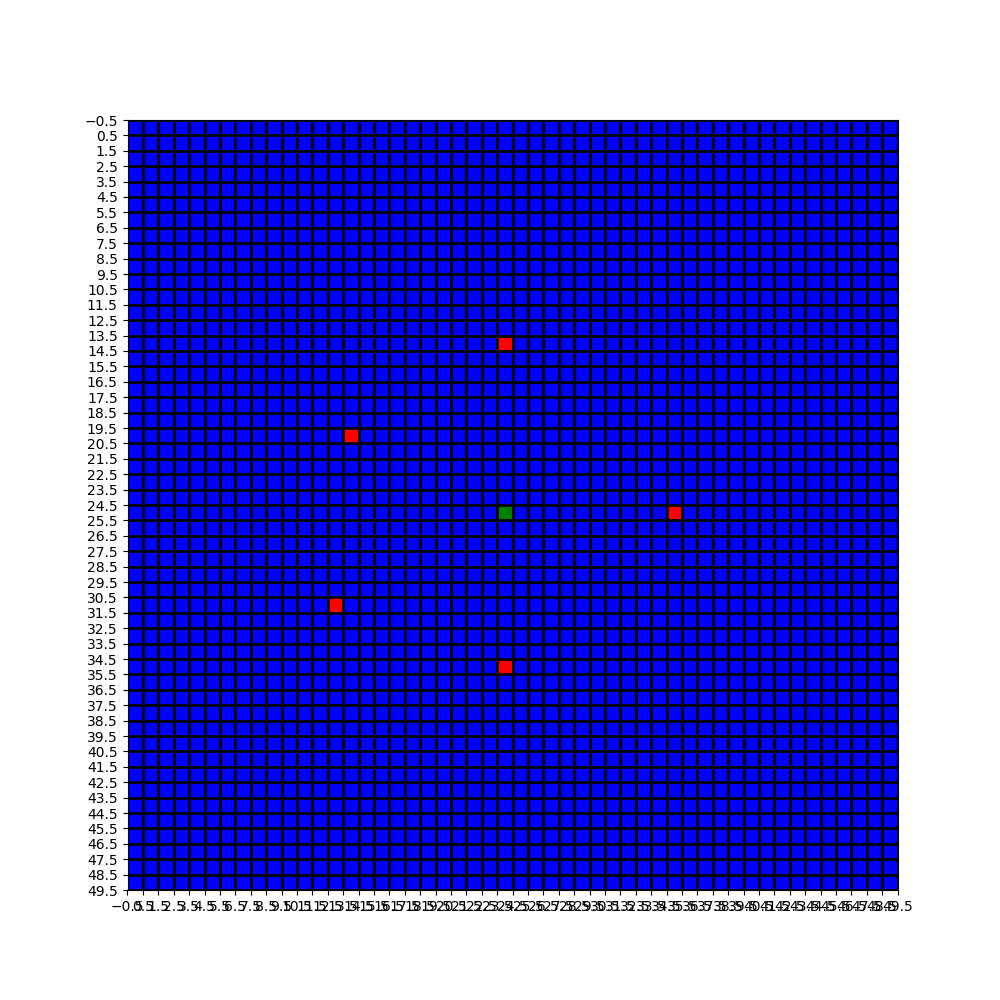

In [11]:
task_3.simulate(50, dijkstra=False)
task_3.animate() #10.6, 9.8

# Task 4: Obstacle Avoidance 

### Without Obstacle Avoidance

We see that as expected, without obstacle avoidance, the pedestrians simply break the obstacle barrier and go through it. This is ofcourse not natural behavior (unless the pedestrians are really strong ;) ) Hence we will apply some basic obstacle avoidance.

Note that we conduct the bottleneck experiment with a lesser number of pedestrians as simulating 150 pedestrians was too expensive for our simulator.

<IPython.core.display.Javascript object>


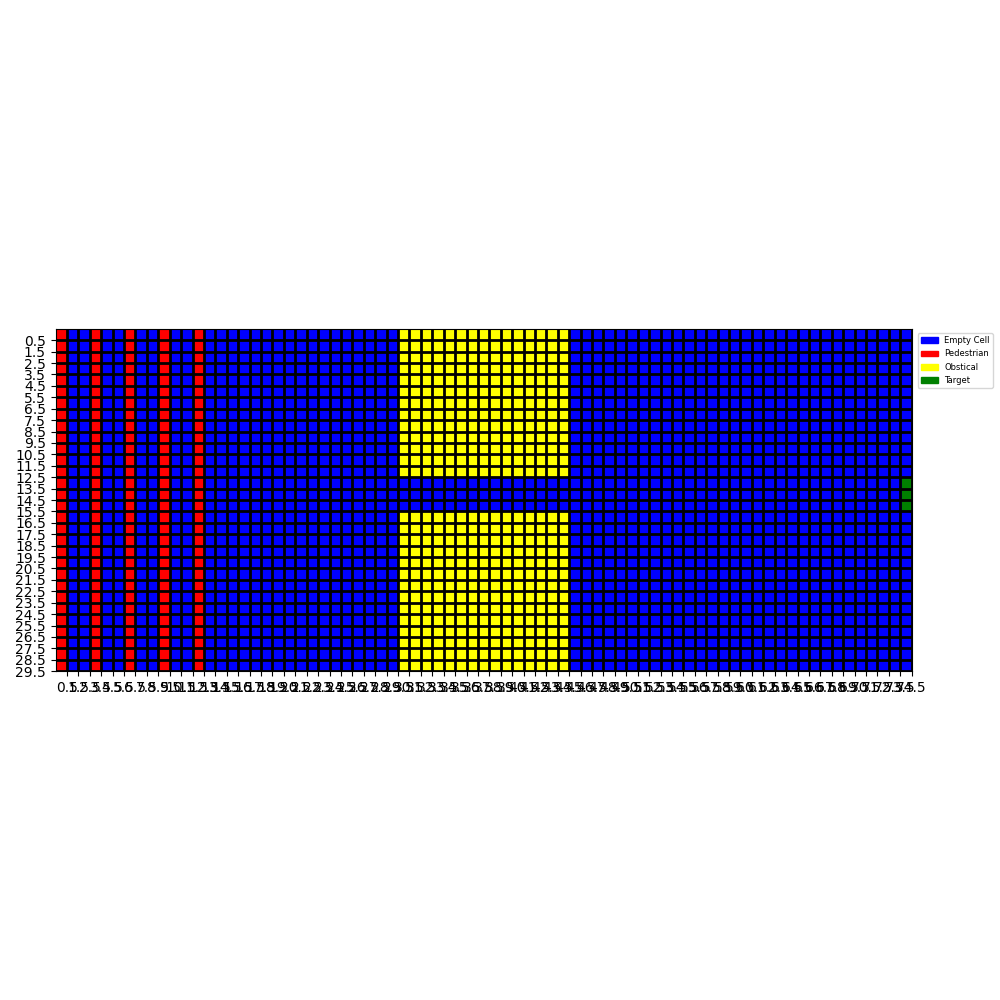

In [12]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4, obstacle_avoidance=False)
visualize_state(task_4.to_array())

In [ ]:
task_4.simulate(60, obstacle_avoidance=False)
task_4.animate()

### Rudementary Obstacle Avoidance

We have now implemented some basic obstacle avoidance which is as simple as setting a rule that pedestrians should not step into a cell that is classified as an obstacle. This is done by assigning the obstacle cells with a very high cost. 

We can observe that now the pedestrians follow a more "Natural" behavior and do not barge through obstacles as they did before.

<IPython.core.display.Javascript object>


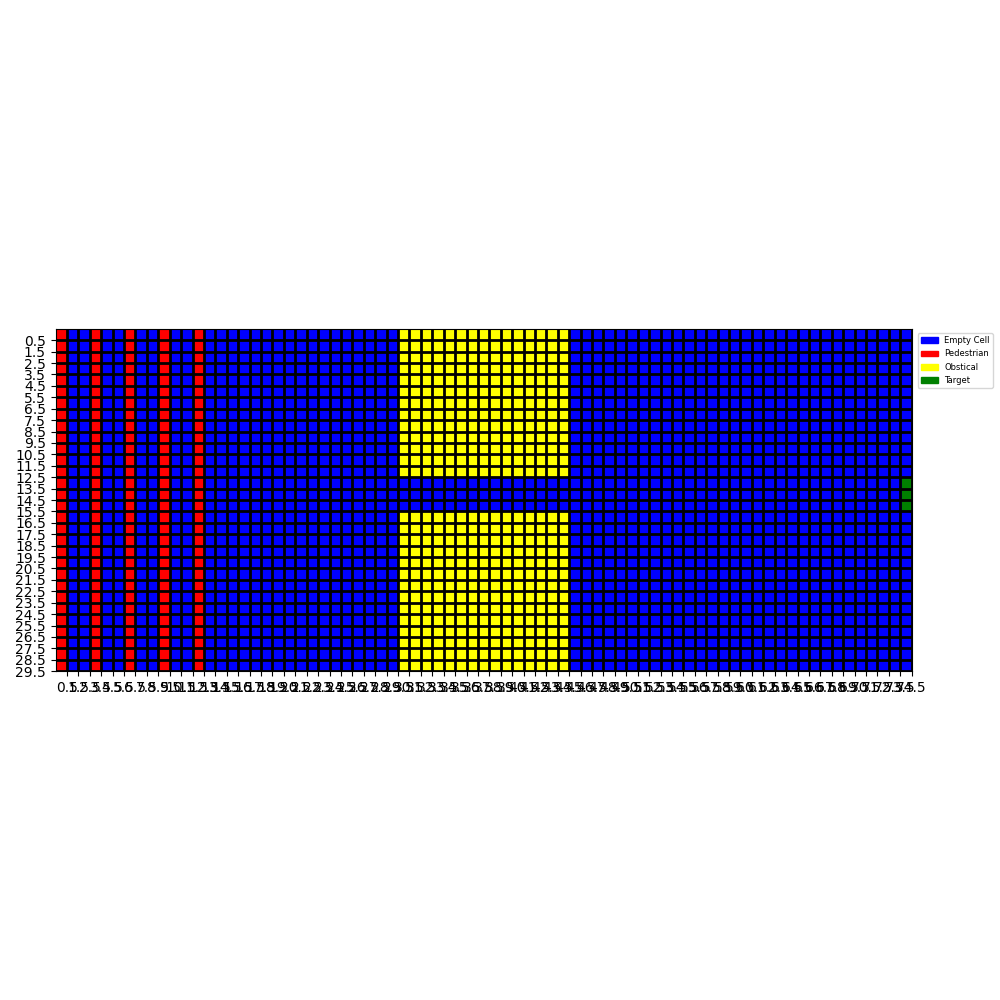

In [8]:
with open('./scenarios/task_4.csv', newline='') as csvfile:
    task_4 = np.array(list(csv.reader(csvfile))).astype(int)
    task_4 = parser_array2obj(task_4)
visualize_state(task_4.to_array())

<IPython.core.display.Javascript object>


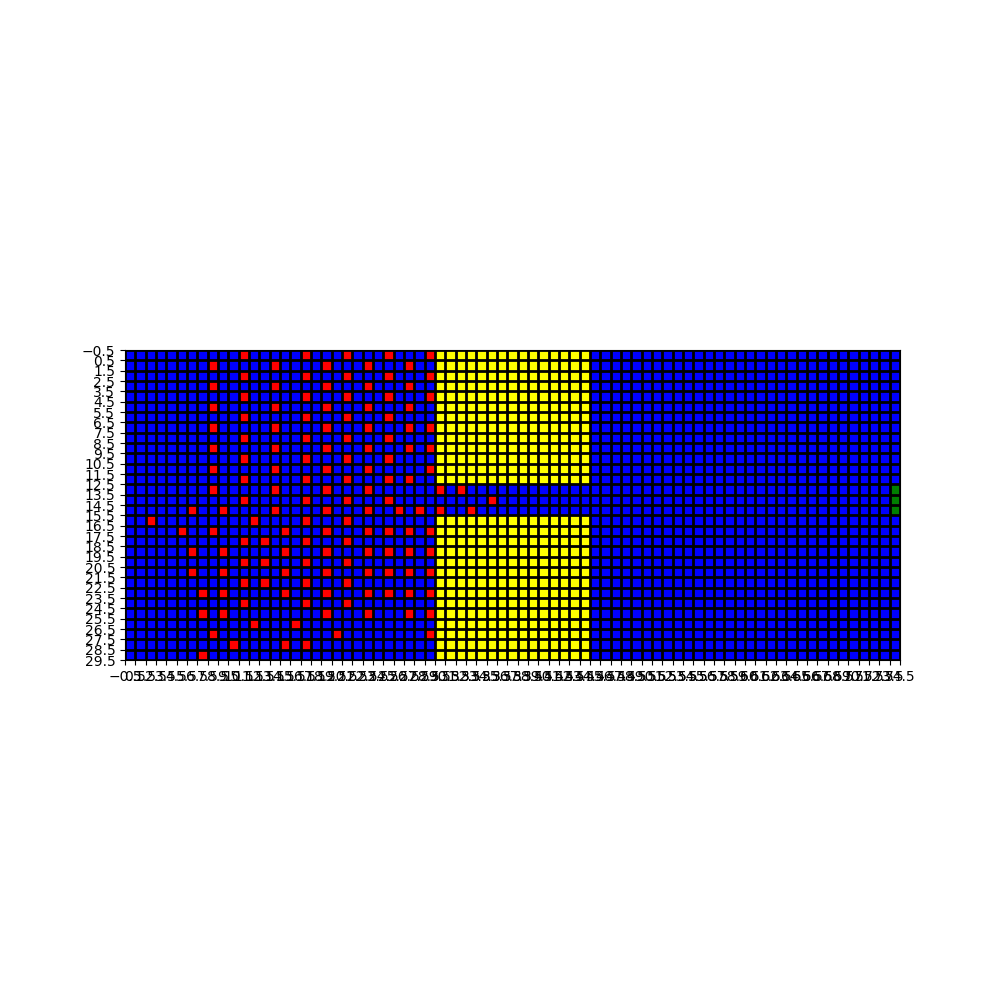

In [10]:
task_4.simulate(60, dijkstra=True)
task_4.animate()

### The Chicken Test
Rudementary obstacle avoidance implemented, we see how our simulator now performs on the chicken test with 1 pedestrian only.

<IPython.core.display.Javascript object>


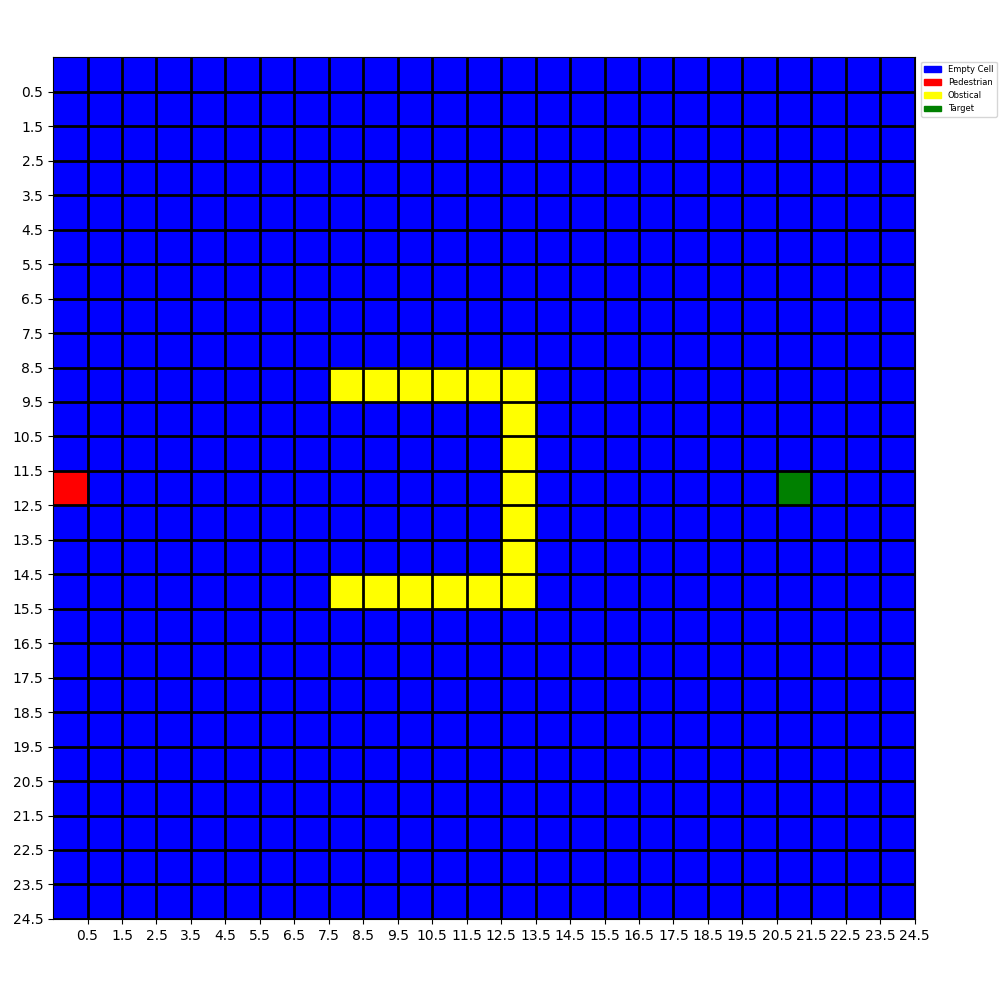

In [13]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)
visualize_state(chicken_test.to_array())

**As expected, our poor pedestrian gets stuck in the trap because the cells simply have a cost which does not take into account how paths are connected.**

The simulation was took 26 steps and was executed in 7.8 seconds.


<IPython.core.display.Javascript object>


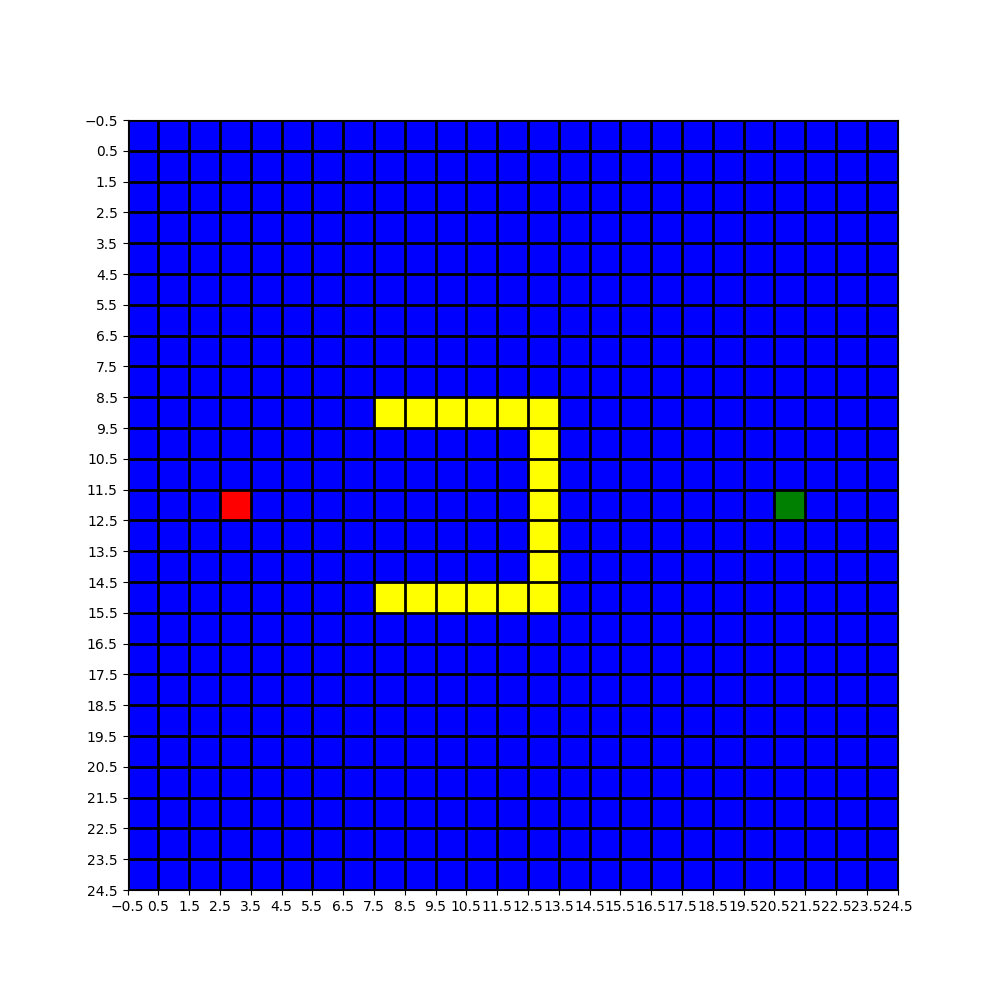

In [14]:
chicken_test.simulate(25, dijkstra=False)
chicken_test.animate()

### The Dijkstra's Algorithm
We implement the Dijkstra's algorithm to flood the cells with utilitiy values starting from the targets i.e. targets have a cost of 0. 

This allows a kind of look ahead when we simulate our pedestrians since now we have also taken into account the obsticals. Essentially the entire grid is treated as a well connected bi-directional graph instead of the points where the obsticals exist. These cells are treated as unconnected nodes on the graph. This is shown below:

<table>
  <tr>
    <td><img src="./figures/fully_connected.png" width=270 height=480></td>
    <td><img src="./figures/graph_with_obj.png" width=270 height=480></td>
  </tr>
      <tr>
    <td>Fully Connected Bi-Directional Graph</td>
     <td>Bi-directional Graph with Obstacle </td>
  </tr>
 </table>


### Chicken Test Part 2: The dijkstra's algorithm
We now plot the cell costs that are calculated with the help of the dijkstra's algorithm with the target cell(s) having a cost of 0. This is represented in the color map of the chicken test below

<IPython.core.display.Javascript object>


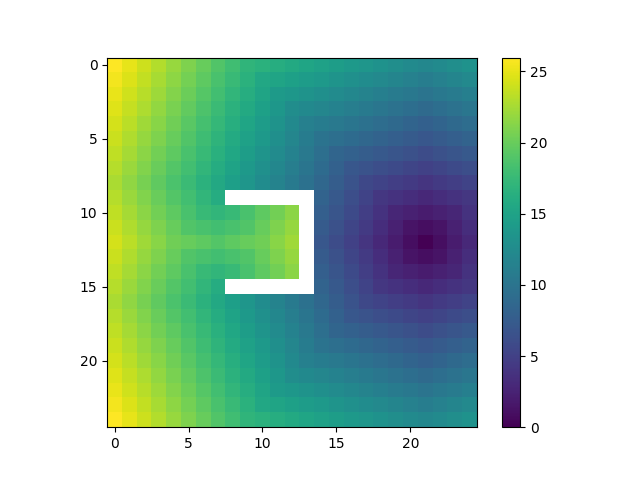

The simulation was took 2 steps and was executed in 0.6 seconds.


In [17]:
with open('./scenarios/chicken_test.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)

fig = plt.figure()
chicken_test.simulate(1, dijkstra=True)
plt.imshow(chicken_test.get_dijkstra())
plt.colorbar()

Let us now simulate the chicken test again this time with the dikstra's algorithm

The simulation was took 26 steps and was executed in 7.8 seconds.


<IPython.core.display.Javascript object>


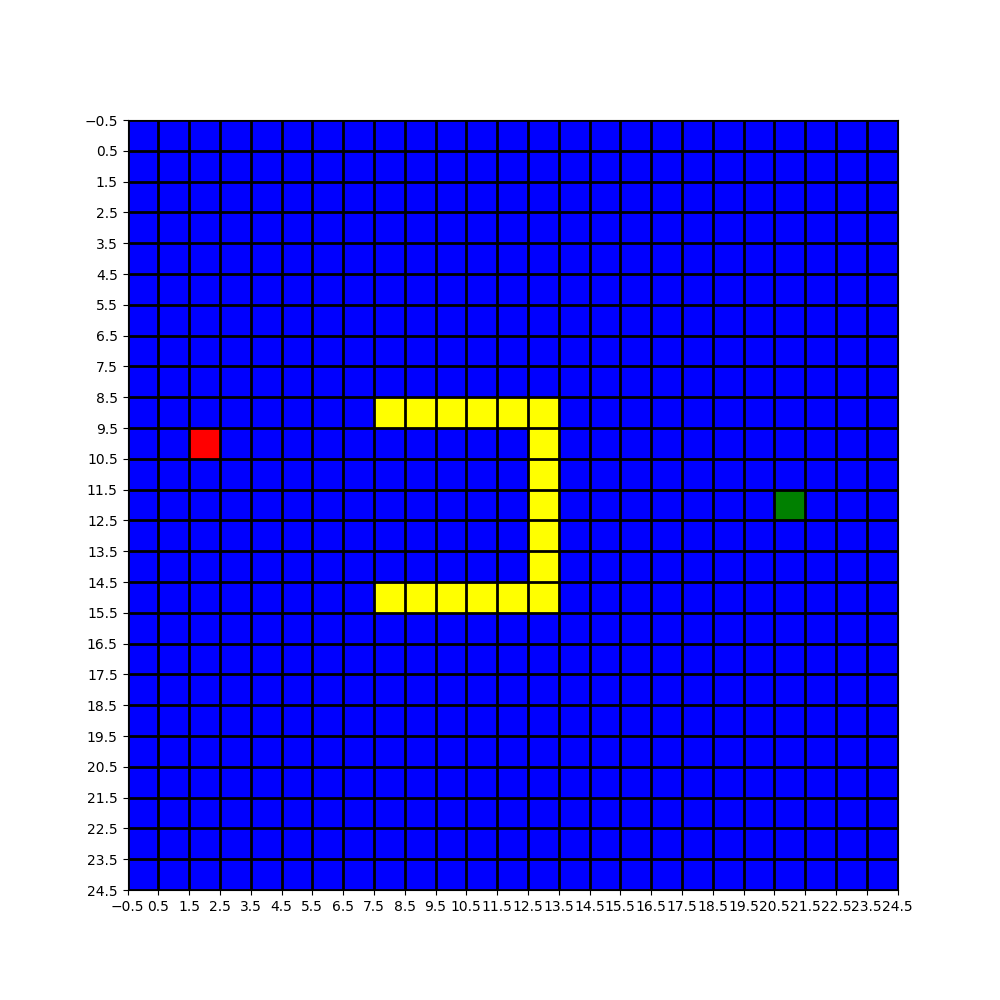

In [18]:
chicken_test.simulate(25, dijkstra=True)
chicken_test.animate()

# Task 5: Integration Testing - RiMEA Scenarios

### RiMEA 1
In this test we need to assess if the speed at which a certain pedestrian walks towards the target translates to an accurate simulation time. the scenario is a 40m by 10m corridor. We model each cell as 0.4m and the pedestrian as 0.4m as well so that the pedestrian occupipes 1 cell. 

We first visualize the scenario as always.

<IPython.core.display.Javascript object>


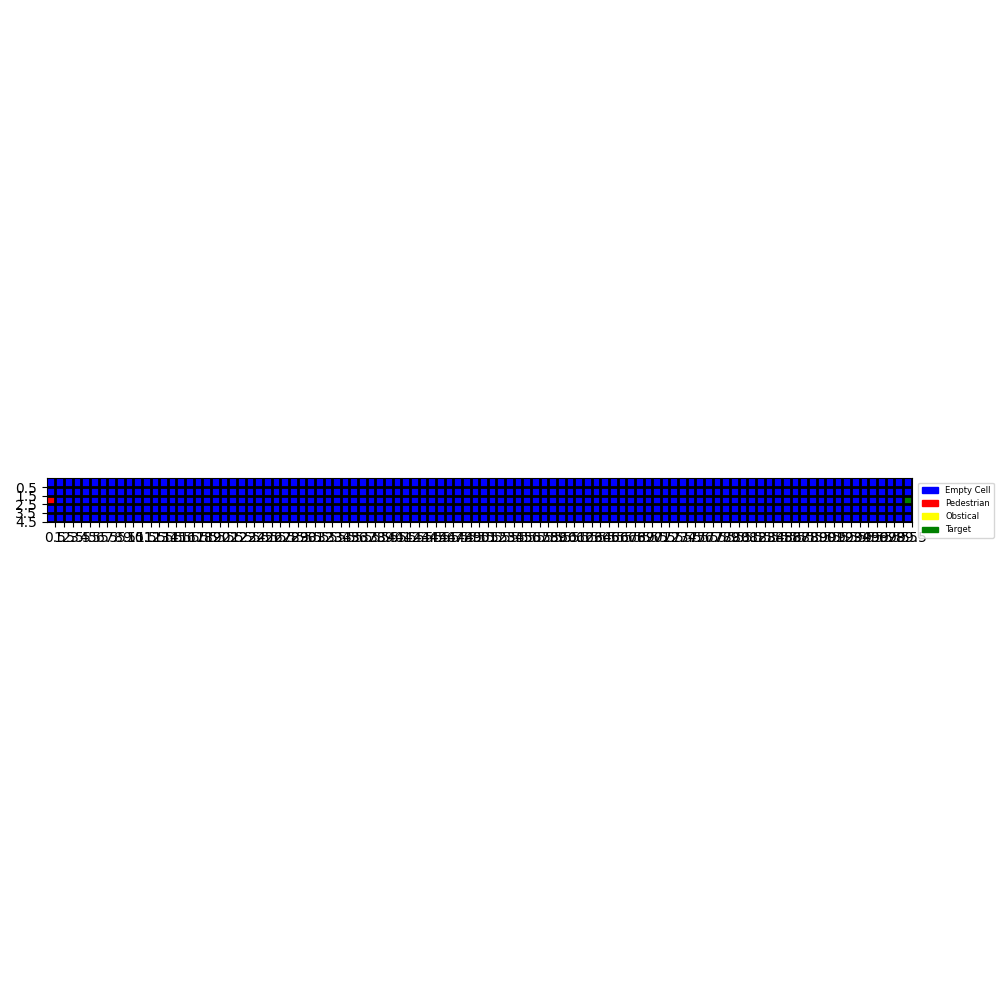

In [19]:
with open('./scenarios/rimea_test1.csv', newline='') as csvfile:
    rimea_1 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_1 = parser_array2obj(rimea_1)
    
cell_size_meters = 0.4
rimea_1.set_cell_size(cell_size_meters)
visualize_state(rimea_1.to_array())

Here we can see the execution of the simulation. In order to see how much time it took for the pedestrian to move from one end to another, we can execute the same simulation with the help of the pygame GUI.

In [ ]:
start_game_gui(rimea_1, max_steps=200, dijkstra=False, step_time=750*cell_size_meters, cell_size=cell_size_meters)

### RiMEA 4

In this scenario, many pedestrians are spread randomly in a grid based on the specified density. Since the scenario is very long (1000m x 10m) and since the pedestrians need to move perpetually we add teleportation boundary conditions such that when pedestrians come at the left end off the grid where the targets exist they are sent back to the initial cells. The scenario becomes a carousel. 

The densities with which the scenario is filled in pedestrians per meter square are 0.5, 1, 2, 3, 4, 5, 6.
This means the cell size needs to be scaled again. In order to fit the largest density, we make the cell size 0.33m such that 1 meter square can cater to a maximum of 9 pedestrians. We can now reduce the size of the grid from an original of 3000 x 30 cells (1000x10 meters) to just 30 x 30 cells (10 x 10 meters).

### Density 0.5 ped/m^2
With a density of 0.5 pedestrians per meter, we notice that in an area of 30/3* 30/3 =  100 meters square we have 100*0.5=50 pedestrians.

We fill the grid randomly with pedestrians.

Adding 49 to the grid.


<IPython.core.display.Javascript object>


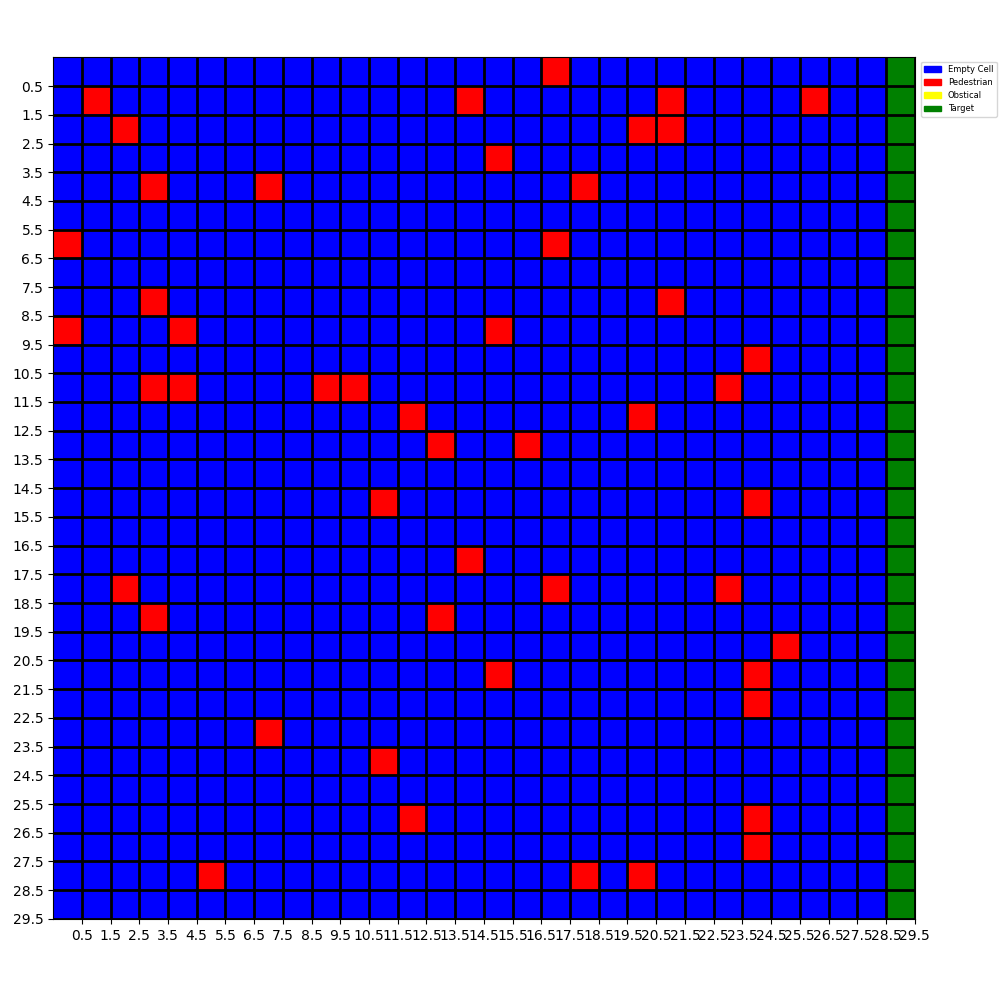

In [5]:
with open('./scenarios/rimea_test4.csv', newline='') as csvfile:
    rimea_4 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_4 = parser_array2obj(rimea_4)

cell_size_meters = 0.3333
rimea_4.set_cell_size(0.3333)
rimea_4.flood_pedestrians(0.5)
visualize_state(rimea_4.to_array())

#### Measuring Points

We will set two measuring points which will record the following information:
1. Speed of pedestrian that passed through cell.
2. Density of pedestrians around that point when a pedestrian passed though them.

In [6]:
# Actual Measuring Point
rimea_4.add_measuring_point(15,5)
rimea_4.add_measuring_point(15,6)
rimea_4.add_measuring_point(16,5)
rimea_4.add_measuring_point(16,6)

# Control Point
rimea_4.add_measuring_point(15,20)
rimea_4.add_measuring_point(15,21)
rimea_4.add_measuring_point(16,20)
rimea_4.add_measuring_point(16,21)

# We delete the log file incase it already exists.
if Path("./logs/measuring_points_logs.csv").exists():
    os.remove("logs/measuring_points_logs.csv")


#### Boundary Conditions
For this task we also need to implement boundary conditions as discussed above. We do this in the notebook.

In [7]:
start_game_gui(rimea_4, max_steps=30, dijkstra=False, step_time=750*cell_size_meters, cell_size=cell_size_meters, periodic_boundary = True)
copyfile("./logs/measuring_points_logs.csv", "./logs/measuring_points_logs_rimea_4_density0.5.csv")

'./logs/measuring_points_logs_rimea_4_density0.5.csv'

### Collecting Data for other densities 

In [34]:
execute_rimea_4()

Adding 99 to the grid.
Adding 199 to the grid.
Adding 299 to the grid.
Adding 399 to the grid.
Adding 499 to the grid.
Adding 599 to the grid.


### Plotting the Fundamental Diagram

We plot the measured speed against the measured density for the 7 different density cases of the RiMEA 4 scenario.

In [53]:
densities_arr = ["0.5", "1","2", "3","4","5","6"]
densities = []
speeds = []
for density in densities_arr:
    file = './logs/measuring_points_logs_rimea_4_density' + density + '.csv'
    df_rimea_4 = pd.read_csv(file)
    df_rimea_4 = df_rimea_4.iloc[-60:]
    df_rimea_4 = df_rimea_4.describe()
    speeds.append(df_rimea_4['speed'].iloc[1])
    densities.append(df_rimea_4['density'].iloc[1])


<IPython.core.display.Javascript object>


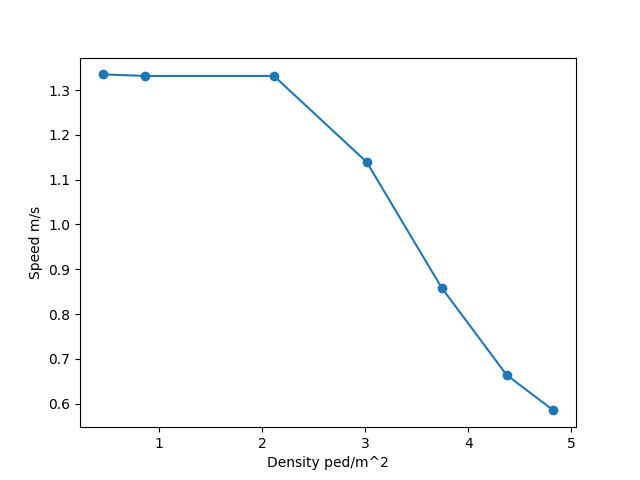

In [54]:
fig, ax = plt.subplots(1,1)
ax.plot(densities, speeds, 'o-')
ax.set_xlabel("Density ped/m^2")
ax.set_ylabel("Speed m/s")
fig.savefig("./figures/fundamental_diagram.pdf")

In [160]:
print(speeds, densities)

[0.7467593894551804, 0.39234961184481665, 0.29667158074537336, 0.25298875948855676, 0.19895856469865428, 0.16675663482397338, 0.14958525337090042] [0.46540440204493716, 0.8965319544303975, 1.2836537925328113, 1.6152539412754192, 2.1700337089890107, 2.6645443201270784, 3.053978291312093]


### RiMEA 6
We simulate the passage of 20 pedestrians around a corner. The pedestrians must navigate while avoiding the obstacle which in this case is the entire wall. In order to match the dimensions in the RiMEA test case, we rescale our cells such that each cell is of length 0.5 meters.

<IPython.core.display.Javascript object>


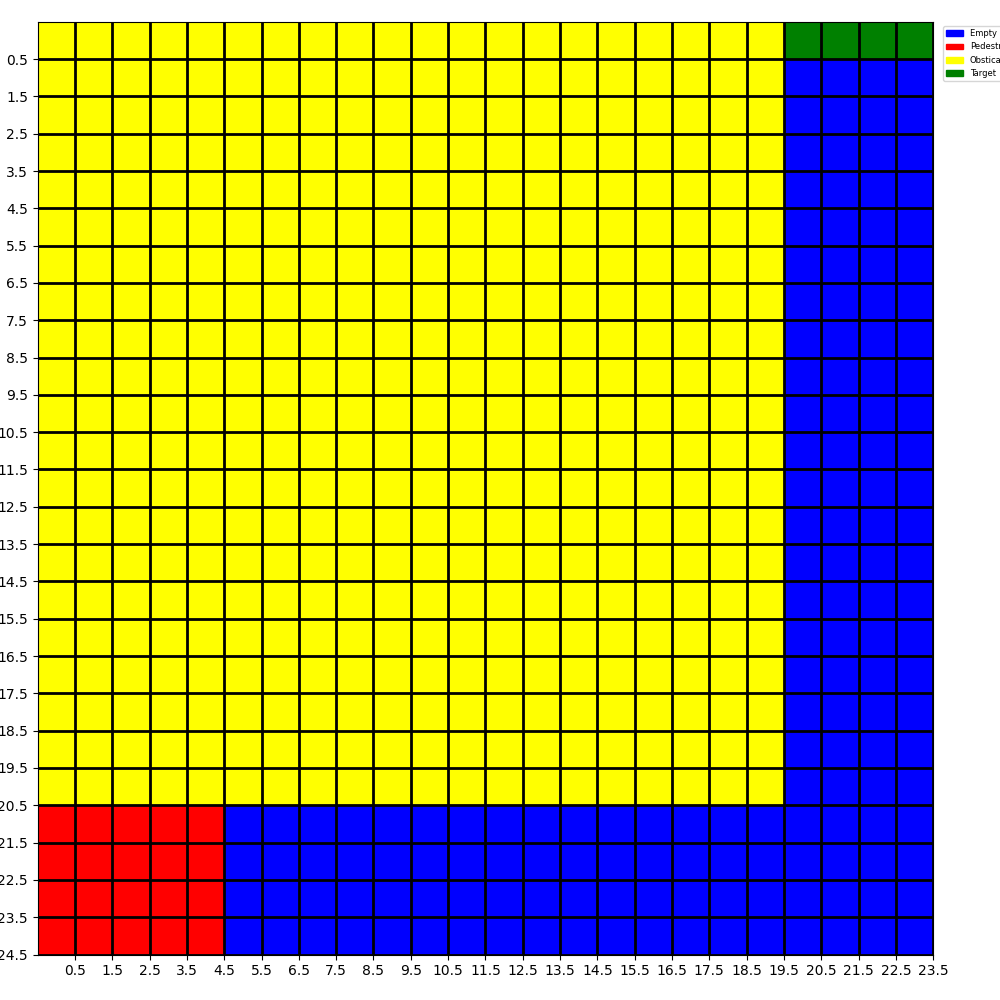

In [28]:
with open('./scenarios/rimea_test6.csv', newline='') as csvfile:
    rimea_6 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_6 = parser_array2obj(rimea_6)
    
cell_size_meters = 0.5
visualize_state(rimea_6.to_array())

We can observe that the pedestrians can easily navigate around the corner and can also observe the repulsion between pedestrians.

The simulation was took 36 steps and was executed in 10.8 seconds.


<IPython.core.display.Javascript object>


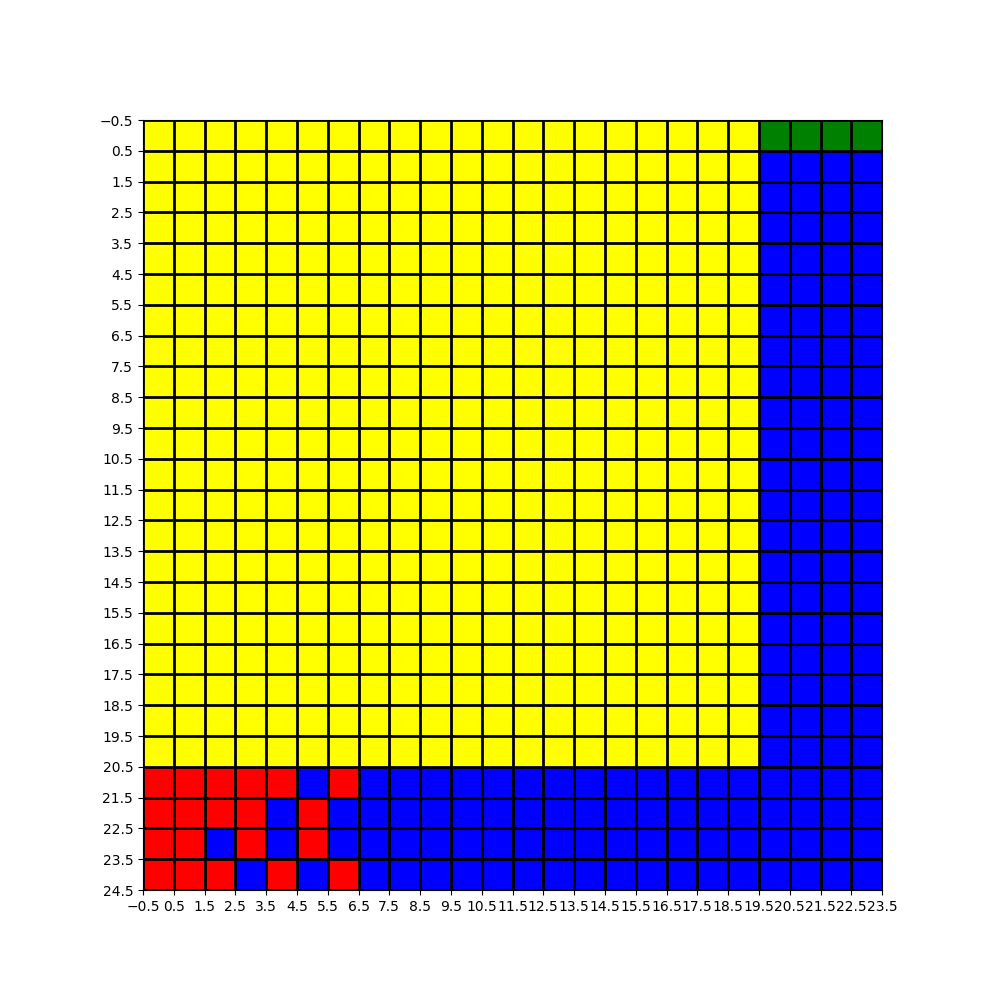

In [29]:
rimea_6.simulate(35)
rimea_6.animate()

### RiMEA 7

We used some data points from the Figure 2 of the RiMEA guidelines and then used cubic spline interpolation to generate a function that takes the age of the pedestrian as an input and outputs the speed based on the distribtution. We use this function to instantiate 50 pedestrians of random ages and their corresponding speeds and see if we can generate the same distribution as given in the RiMEA guidelines.

Adding 49 to the grid.


<IPython.core.display.Javascript object>


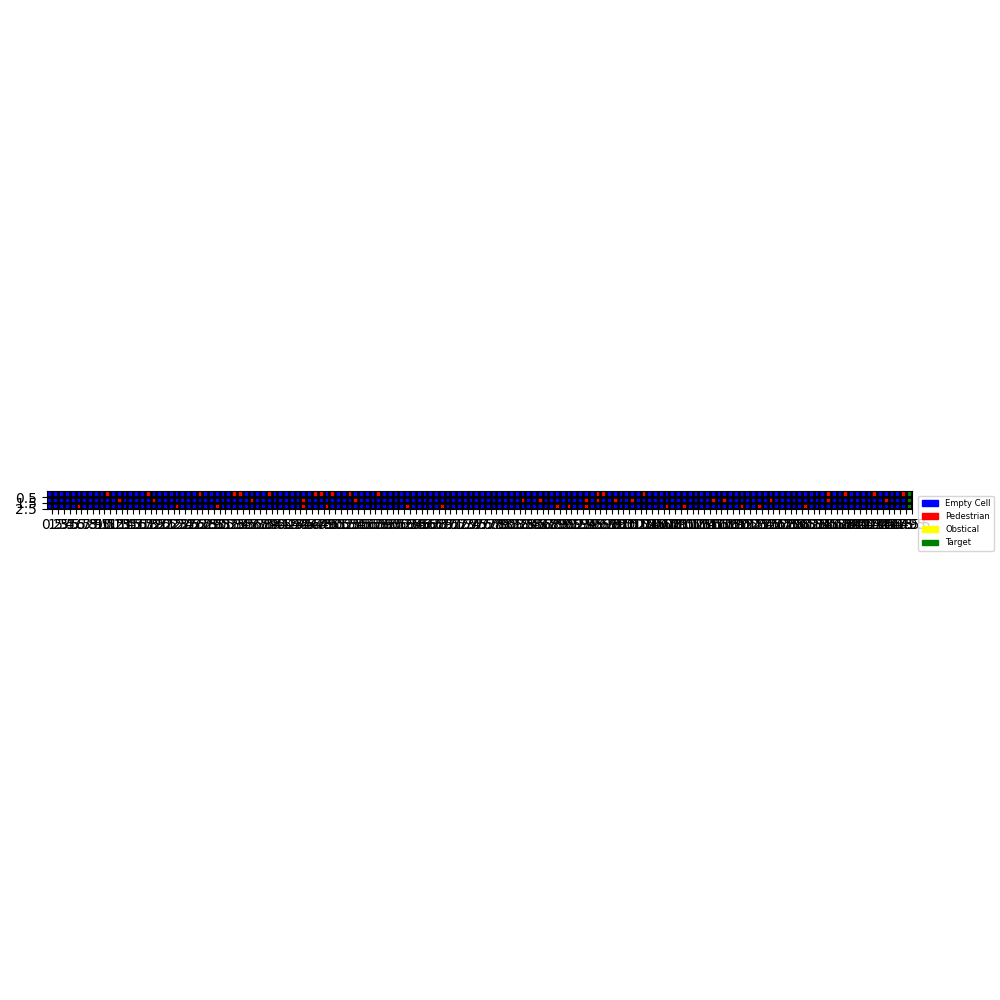

In [2]:
with open('./scenarios/rimea_test7.csv', newline='') as csvfile:
    rimea_7 = np.array(list(csv.reader(csvfile))).astype(int)
    rimea_7 = parser_array2obj(rimea_7)
    
rimea_7.flood_pedestrians(0.111, distributed_speed=True)
visualize_state(rimea_7.to_array())

In [3]:
# Measuring Points
rimea_7.add_measuring_point(0,10)
rimea_7.add_measuring_point(1,10)
rimea_7.add_measuring_point(2,10)
rimea_7.add_measuring_point(0,40)
rimea_7.add_measuring_point(1,40)
rimea_7.add_measuring_point(2,100)
rimea_7.add_measuring_point(0,100)
rimea_7.add_measuring_point(1,100)
rimea_7.add_measuring_point(2,100)
# We delete the log file incase it already exists.
if Path("./logs/measuring_points_logs.csv").exists():
    os.remove("logs/measuring_points_logs.csv")
    
start_game_gui(rimea_7, max_steps=100, dijkstra=False, step_time=1000, cell_size=1.0, periodic_boundary = False, constant_speed = False)
copyfile("./logs/measuring_points_logs.csv", "./logs/measuring_points_logs_rimea_7.csv")

FileNotFoundError: [Errno 2] No such file or directory: './logs/measuring_points_logs.csv'

<IPython.core.display.Javascript object>


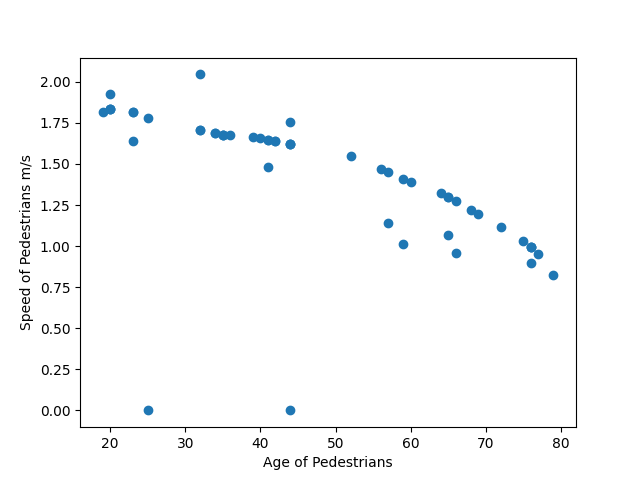

In [62]:
file = './logs/measuring_points_logs_rimea_7.csv'
df_rimea_7 = pd.read_csv(file)
df_rimea_7
fig, ax = plt.subplots(1,1)
ax.scatter(df_rimea_7.Pedestrian_Age, df_rimea_7.speed)
ax.set_xlabel("Age of Pedestrians")
ax.set_ylabel("Speed of Pedestrians m/s")
fig.savefig("./figures/age_vs_speed.pdf")